# Analyze A/B Test Results 

## Introduction

This is an A/B test run using data from an e-commerce website. The company running the website are trialling a new homepage which may or may not be more attractive to new customers. The company wants to know whether the new page is better than the old page.

The goal of the test is to work out whether the company should:
- Implement the new webpage, 
- Keep the old webpage, or 
- Perhaps run the experiment longer to make their decision.

All data were provided by Udacity.


<a id='probability'></a>
## Exploring the dataset and calculating some basic probabilities

To get started, let's import our libraries.

In [1]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
%matplotlib inline
random.seed(42)

Reading in the dataset from the `ab_data.csv` file and taking a look at the top few rows here:

In [2]:
ab_data = pd.read_csv('ab_data.csv')
ab_data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


Comments:

Two webpages were provided, the old page and the new page.
The 'converted' column contains 0s and 1s. The 0 indicates the customer did not sign up for any products. The 1 indicates the customer did sign up.
There are two groups, the control group (using the old page which the company is already using) and the treatment group, which are using the new page.

Use the cell below to find the number of rows in the dataset.

In [3]:
ab_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294478 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   user_id       294478 non-null  int64 
 1   timestamp     294478 non-null  object
 2   group         294478 non-null  object
 3   landing_page  294478 non-null  object
 4   converted     294478 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 11.2+ MB


There are 294478 rows.

Finding the number of unique users in the dataset.

In [4]:
ab_data.nunique()

user_id         290584
timestamp       294478
group                2
landing_page         2
converted            2
dtype: int64

There are 290584 unique users.

Finding the proportion of users converted (converted users are users who sign up to the website).

In [5]:
ab_data.loc[(ab_data['converted'] == 1)]

,user_id,timestamp,group,landing_page,converted
4,864975,2017-01-21 01:52:26.210827,control,old_page,1
6,679687,2017-01-19 03:26:46.940749,treatment,new_page,1
8,817355,2017-01-04 17:58:08.979471,treatment,new_page,1
9,839785,2017-01-15 18:11:06.610965,treatment,new_page,1
15,644214,2017-01-22 02:05:21.719434,control,old_page,1
...,...,...,...,...,...
294396,838593,2017-01-15 09:56:31.455023,treatment,new_page,1
294405,712217,2017-01-11 10:34:30.176801,control,old_page,1
294420,795742,2017-01-09 01:06:58.299207,control,old_page,1
294430,733871,2017-01-21 17:54:08.810964,treatment,new_page,1


The proportion converted = 35237/290584 = 12.1%

Finding the number of times when the "group" is `treatment` but "landing_page" is not a `new_page`. This is important as the treatment group was meant to be assigned the new page rather than the old page.

In [6]:
ab_data.loc[(ab_data['group']=='treatment') & (ab_data['landing_page'] == 'old_page')]

,user_id,timestamp,group,landing_page,converted
308,857184,2017-01-20 07:34:59.832626,treatment,old_page,0
327,686623,2017-01-09 14:26:40.734775,treatment,old_page,0
357,856078,2017-01-12 12:29:30.354835,treatment,old_page,0
685,666385,2017-01-23 08:11:54.823806,treatment,old_page,0
713,748761,2017-01-10 15:47:44.445196,treatment,old_page,0
...,...,...,...,...,...
293773,688144,2017-01-16 20:34:50.450528,treatment,old_page,1
293817,876037,2017-01-17 16:15:08.957152,treatment,old_page,1
293917,738357,2017-01-05 15:37:55.729133,treatment,old_page,0
294014,813406,2017-01-09 06:25:33.223301,treatment,old_page,0


1965 times.

Do any of the rows have missing values?

In [7]:
ab_data.isnull().sum()

user_id         0
timestamp       0
group           0
landing_page    0
converted       0
dtype: int64

No. (Good!)

 
In a particular row, the **group** and **landing_page** columns should have either of the following acceptable values:

|user_id| timestamp|group|landing_page|converted|
|---|---|---|---|---|
|XXXX|XXXX|`control`| `old_page`|X |
|XXXX|XXXX|`treatment`|`new_page`|X |


It means the `control` group users should match with `old_page`, and `treatment` group users should be matched with the `new_page`. 

Rows which are incorrectly matched need to be removed as we cannot work out the correct matching.

In [8]:
# Removing the incorrectly labelled rows:

treatment = ab_data[(ab_data['group']=='treatment') & (ab_data['landing_page'] == 'new_page')]
control = ab_data[(ab_data['group']=='control') & (ab_data['landing_page'] == 'old_page')]
df2 = pd.concat([treatment,control], ignore_index='True')

In [9]:
# Double Check all of the incorrect rows were removed from df2 - 
# Output of the statement below should be 0
df2[((df2['group'] == 'treatment') == (df2['landing_page'] == 'new_page')) == False].shape[0]

0

We now need to check for duplicates. How many unique **user_id**s are in **df2**?

In [10]:
df2.nunique()

user_id         290584
timestamp       290585
group                2
landing_page         2
converted            2
dtype: int64

There is one **user_id** repeated in **df2**.

In [11]:
df2[df2.duplicated(subset='user_id')]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


The duplicated user id is 773192.

Finding the rows for the duplicate **user_id**? 

In [12]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
938,773192,2017-01-09 05:37:58.781806,treatment,new_page,0
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


Removing one of the rows with a duplicate user_id, from the df2 dataframe, to finish the cleaning process.

In [13]:
df2 = df2.drop_duplicates(subset='user_id',keep='last')

In [14]:
df2[df2.user_id==773192]

,user_id,timestamp,group,landing_page,converted
1404,773192,2017-01-14 02:55:59.590927,treatment,new_page,0


### Calculating some basic probabilities

The first question to ask is whether using the new page leads to a higher rate of conversion. To do this, we should calculate and compare probabilities of conversion for both pages *and* for conversion given either page could have been presented to the user.


So, what is the probability of an individual converting regardless of the page they receive?<br><br>

In [15]:
N_conversions = df2[(df2['converted'] == 1)].count()
N_rows = df2.count()

In [16]:
p_convert = N_conversions/N_rows
p_convert.values[0]

0.11959708724499628

Given that an individual was in the `control` group, what is the probability they converted?

In [17]:
control = df2[df2['group']=='control'].count()
p_old = df2[df2['group']=='control']['converted'].sum()/control
p_old.values[0]

0.1203863045004612

Given that an individual was in the `treatment` group, what is the probability they converted?

In [18]:
treatment = df2[df2['group']=='treatment'].count()
p_new = df2[df2['group']=='treatment']['converted'].sum()/treatment
p_new.values[0]

0.11880806551510564

In [19]:
# Calculating the actual difference (obs_diff) between the conversion rates for the two groups.

obs_diff = p_new - p_old
obs_diff.values[0]

-0.0015782389853555567

What is the probability that an individual received the new page?

In [20]:
new_page = df2[df2['landing_page']=='new_page'].count()
new_page.values[0]

145310

In [21]:
p_new_page = new_page['landing_page']/N_rows
p_new_page.values[0]

0.5000619442226688

The observed difference is about 0.158%. The probability of converting on the old page is slightly greater, but it is not clear whether this observation is statistically significant...

<a id='ab_test'></a>
## Part II - A/B Test

Since a timestamp is associated with each event, we could run a hypothesis test continuously as long as you observe the events. 

However, then the hard questions would be: 
- Do you stop as soon as one page is considered significantly better than another or does it need to happen consistently for a certain amount of time?  
- How long do you run to render a decision that neither page is better than another?  

For now, I will run an A/B test based on all the data provided.  

Stating the null and alternative hypotheses:

> $H_0$: $p_{old}$ >= $p_{new}$, with a type I error rate of 5%.

> $H_1$: $p_{new}$ > $p_{old}$, with a significance level of 5%.

In order to carry out a more reliable test, a bootstrap sample will be simulated. 

> First a bootstrap sample will be simulated for both groups and a conversion rate calculated for each group.

> The difference in conversion rate between the groups will be calculated.

> This process will be carried out 10,000 times and the results used to calculate an estimate for the observed difference in probabilities for each group.

Carrying out the test this way allows us to use a great deal more data and also work out if the difference in probability observed (at the beginning of this project) is statistically significant. If it is, one page will be deemed better than the other!

Finding the conversion rate for $p_{new}$ under the null hypothesis:

In [22]:
p_new = (df2.converted == 1).mean()

In [23]:
p_new

0.11959708724499628

Finding the conversion rate for $p_{old}$ under the null hypothesis? 

In [24]:
p_old = (df2.converted == 1).mean()
p_old

0.11959708724499628

Finding $n_{new}$, the number of individuals in the treatment group? <br><br>

In [25]:
N_new = treatment['landing_page']
N_new

145310

Finding $n_{old}$, the number of individuals in the control group?

In [26]:
N_old = control['landing_page']
N_old

145274

**Simulating bootstrap samples for both groups:**

Simulating $n_{new}$ transactions with a conversion rate of $p_{new}$ under the null hypothesis.  <br><br>


In [27]:
# Simulating 10,000 samples for the treatment group:
#p_old = p_old['landing_page']
new_converted_simulation = np.random.binomial(N_new,p_old,10000)/N_new
new_converted_simulation

array([0.11995045, 0.11891129, 0.11882183, ..., 0.11948937, 0.12051476,
       0.11961324])

In [28]:
# Simulating 10,000 samples for the control group:

old_converted_simulation = np.random.binomial(N_old,p_old,10000)/N_old
old_converted_simulation

array([0.12097141, 0.12018668, 0.120345  , ..., 0.1187549 , 0.11964288,
       0.11860347])

Finding the difference in the "converted" probability $(p{'}_{new}$ - $p{'}_{old})$ for all simulated samples:

In [29]:
p_diffs = old_converted_simulation - new_converted_simulation

In [30]:
# Sampling distribution 
p_diffs

array([ 0.00102095,  0.00127539,  0.00152317, ..., -0.00073446,
       -0.00087188, -0.00100977])

Now we have 10,000 values for the difference in conversion rate between the control and treatment groups and can start to examine the distribution of these values.

**Exploring the data using a histogram:**  

A histogram will show the general distribution. We can also plot the probability difference observed earlier, using plt.axvline().

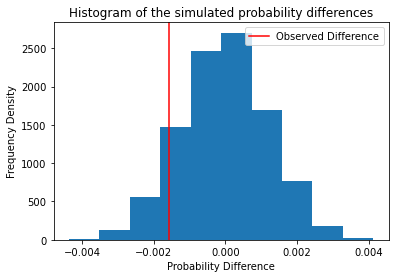

In [31]:
plt.hist(p_diffs)
plt.axvline(x=obs_diff.values[0],color='r',label='Observed Difference')
plt.legend()
plt.ylabel('Frequency Density')
plt.xlabel('Probability Difference')
plt.title('Histogram of the simulated probability differences')
plt.show()

To find the observed p-value, we should calculate what proportion of the **p_diffs** are greater than the actual difference observed in the `df2` data.

In [32]:
proportion = (p_diffs > obs_diff.values[0]).sum()
proportion_value = proportion/len(p_diffs)
proportion_value

0.899

This is the observed p-value. It signifies that about 90% of the data lie above the observed value. Since we are using a type I error rate of 5%, this corresponds to a 10% significance level and so the p-value observed is not enough to reject the null hypothesis.

**Using built-in models to evaluate the results:**

The above analysis uses many samples and one observation. It can be performed much more quickly using inbuilt libraries, however.

This next part uses statsmodels to compute the p-value.

In [33]:
import statsmodels.api as sm


import numpy as np
from statsmodels.stats.proportion import proportions_ztest

convert_new = df2[df2['group']=='treatment']['converted'].sum()
convert_old = df2[df2['group']=='control']['converted'].sum()

n_old = control['landing_page']
n_new = treatment['landing_page']

# array with the numbers of converted customers in both control and treatment groups
count = np.array([convert_old, convert_new])
# total number of observations in each group
number_of_obs = np.array([n_old, n_new])
# Calculates the p-value for these two samples
stat, pval = proportions_ztest(count, number_of_obs, alternative='smaller')

In [34]:
pval

0.9050583127590245

The p-value is about 90.5%. This is quite close to the value observed earlier (90.8%).

Again, the conclusion is the same: the company should fail to reject the null hypothesis, as this p-value corresponds to a probability of 9.5%, which is greater than the Type I error rate of 5%.


---
### Using a two-sample z-test to model the probability difference between the two groups
Another way for comparing the mean of two independent and normal distribution is a **two-sample z-test**. You can perform the Z-test to calculate the Z_score, as shown in the equation below:

$$
Z_{score} = \frac{ (p{'}_{new}-p{'}_{old}) - (p_{new}  -  p_{old})}{ \sqrt{ \frac{\sigma^{2}_{new} }{n_{new}} + \frac{\sigma^{2}_{old} }{n_{old}}  } }
$$

where
- $p{'}$ is the "converted" success rate in the sample
- $p_{new}$ and $p_{old}$ are the "converted" success rate for the two groups in the population. 
- $\sigma_{new}$ and $\sigma_{new}$ are the standard deviation for the two groups in the population. 
- $n_{new}$ and $n_{old}$ represent the size of the two groups or samples (it's same in our case)


> A Z-test is performed when the sample size is large, and the population variance is known. This allows us (by the central limit theorem) to use the standardized normal distribution. 

> In a two-sample z-test, the z-score represents the distance or difference between the two "converted" success rates in terms of the standard error. It's useful in this case because we are looking at conversion rates for two different groups and we are interested in the difference between them, rather than their respective conversion rates.

Next step is to make a decision to reject or fail to reject the null hypothesis based on comparing these two values: 

I have used the example below to write the code:
- Example 9.1.2 on this [page](https://stats.libretexts.org/Bookshelves/Introductory_Statistics/Book%3A_Introductory_Statistics_(Shafer_and_Zhang)/09%3A_Two-Sample_Problems/9.01%3A_Comparison_of_Two_Population_Means-_Large_Independent_Samples), courtesy of www.stats.libretexts.org



In [35]:
import statsmodels.api as sm
# ToDo: Complete the sm.stats.proportions_ztest() method arguments
z_score, p_value = sm.stats.proportions_ztest(count, number_of_obs, alternative='smaller')
print(z_score, p_value)

1.3109241984234394 0.9050583127590245


The calculated 2-sample z-test p-value = 90.5%. This is a slight difference from the previous observed measurement but is still not enough to reject the null hypothesis.

The test statistic (the z-score) is a standardised score which corresponds to a probability greater than 5%. Again, this means we fail to reject the null hypothesis.

The values calculated using the proportions_ztest() class agree in terms of final result - failing to reject the null hypothesis - but the values calculated vary by less than 0.1%.

<a id='regression'></a>
### Part III - A regression approach

**Goal:**
Our goal here is to use logistic regression on the data and see if it corroborates the results given by the z-tests.

Logistic regression is appropriate because it is a classifying regression. We have two categories - converted or not converted - which are the outputs we must investigate.

To do this, we need to prepare the dataset a couple of steps further.

 1. We must attach an 'intercept' column. It should be titled `intercept` and be `1` in the entire column. 
 2. We must attach a column titled `ab_page`. This is a dummy variable which shows '1' for the new page and '0' for the old page.

In [39]:
# Creating new intercept column
df2['intercept'] = 1

In [40]:
from sklearn.preprocessing import LabelBinarizer
lb = LabelBinarizer()
df2['ab_page'] = lb.fit_transform(df2['group'])

In [41]:
df2.head()

,user_id,timestamp,group,landing_page,converted,intercept,ab_page
0,661590,2017-01-11 16:55:06.154213,treatment,new_page,0,1,1
1,853541,2017-01-08 18:28:03.143765,treatment,new_page,0,1,1
2,679687,2017-01-19 03:26:46.940749,treatment,new_page,1,1,1
3,817355,2017-01-04 17:58:08.979471,treatment,new_page,1,1,1
4,839785,2017-01-15 18:11:06.610965,treatment,new_page,1,1,1


Now instantiating the logistic regression model and fitting it to the data:

In [42]:
x = df2[['intercept','ab_page']]
y = df2['converted']
model = sm.Logit(y,x)
results = model.fit()

Optimization terminated successfully.
         Current function value: 0.366118
         Iterations 6


**Summary of the model:**

In [43]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290582
Method:                           MLE   Df Model:                            1
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:               8.077e-06
Time:                        12:59:50   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1899
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9888      0.008   -246.669      0.000      -2.005      -1.973
ab_page       -0.0150      0.011     -1.311      0.190      -0.037       0.007
==============================================================================
"""


The p-value from the logistic regression associated with ab_page is 18.99%. 

This is approximately double the p-value calculated earlier. It is because the logistic regression model uses a function symmetric about the probability 0.5.

This p-value is much greater than the error rat of 5% and again we fail to reject the null hypothesis. Although the logistic regression does not perform as well as the z-tests, at least it leads us to the same conclusion . . .

### Weaknesses in the above estimate:

> 1. We cannot assume that the factors we have considered are the only factors which are relevant. To increase the predictive power of the model we should attempt to incorporate other variables which are also good predictors.

> 2. The disadvantage of adding more terms is that the logistic regression model assumes all the input variables are independent. This is not necessarily the case in real life and may disadvantage our model if we include too many other (assumed independent) variables.

> 3. Introducing more variables increases the chance of multicollinearity occurring. This can be mitigated by calculated the *variance inflation factor* for each pair of variables, however. 

### Considering whether the user's country has an impact on the conversion rate:

It might be that users from different countries have different conversion rates and that the new page might be more successful in one country than in another. We can investigate this using logistic regression.

In [45]:
# Read in the countries.csv

countries = pd.read_csv('countries.csv')

In [46]:
# Join with the df2 dataframe
# Create dummy variables for the countries

df_merged = countries.set_index('user_id').join(df2.set_index('user_id'), how='inner')
df_merged = df_merged.join(pd.get_dummies(df_merged.country))
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US
user_id,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0


In [47]:
model2 = sm.Logit(df_merged['converted'],df_merged[['intercept', 'US','UK']])
results = model2.fit()

Optimization terminated successfully.
         Current function value: 0.366116
         Iterations 6


In [48]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290581
Method:                           MLE   Df Model:                            2
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:               1.521e-05
Time:                        13:01:43   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1984
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -2.0375      0.026    -78.364      0.000      -2.088      -1.987
US             0.0408      0.027      1.518      0.129      -0.012       0.093
UK             0.0507      0.028      1.786      0.074      -0.005       0.106
==============================================================================
"""

**Observations:**

> There is an interaction effect between the countries US and UK. There is a difference in their  coefficients of 0.0408 - 0.0507 = -0.099. Although this is small it is still observable.
> It does appear that country had an impact on conversion. The p-value has changed from 0.1899 to 0.1984. This is almost a 1% change.
> Nevertheless the p-value is still above the Type I error rate and we again fail to reject the null hypothesis.


Though we have now looked at the individual factors of country and page on conversion, we would now like to look at an interaction between page and country to see if there are significant effects on conversion.

In [49]:
df_merged['ab_UK'] = df_merged['ab_page'] * df_merged['UK']
df_merged['ab_CA'] = df_merged['ab_page'] * df_merged['CA']

In [50]:
df_merged.head()

,country,timestamp,group,landing_page,converted,intercept,ab_page,CA,UK,US,ab_UK,ab_CA
user_id,,,,,,,,,,,,
834778,UK,2017-01-14 23:08:43.304998,control,old_page,0,1,0,0,1,0,0,0
928468,US,2017-01-23 14:44:16.387854,treatment,new_page,0,1,1,0,0,1,0,0
822059,UK,2017-01-16 14:04:14.719771,treatment,new_page,1,1,1,0,1,0,1,0
711597,UK,2017-01-22 03:14:24.763511,control,old_page,0,1,0,0,1,0,0,0
710616,UK,2017-01-16 13:14:44.000513,treatment,new_page,0,1,1,0,1,0,1,0


In [51]:
logit_mod = sm.Logit(df_merged['converted'], df_merged[['intercept','ab_page','UK','CA','ab_UK', 'ab_CA']])

In [52]:
results3 = logit_mod.fit()

Optimization terminated successfully.
         Current function value: 0.366109
         Iterations 6


In [53]:
results3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:              converted   No. Observations:               290584
Model:                          Logit   Df Residuals:                   290578
Method:                           MLE   Df Model:                            5
Date:                Thu, 30 Dec 2021   Pseudo R-squ.:               3.482e-05
Time:                        13:01:48   Log-Likelihood:            -1.0639e+05
converged:                       True   LL-Null:                   -1.0639e+05
Covariance Type:            nonrobust   LLR p-value:                    0.1920
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept     -1.9865      0.010   -206.344      0.000      -2.005      -1.968
ab_page       -0.0206      0.014     -1.505      0.132      -0.047       0.006
UK            -0.0057      0.019     -0.306      0.760      -0.043       0.031
CA            -0.0175      0.038     -0.465      0.642      -0.091       0.056
ab_UK          0.0314      0.027      1.181      0.238      -0.021       0.084
ab_CA         -0.0469      0.054     -0.872      0.383      -0.152       0.059
==============================================================================
"""


> The p-value has changed by a very small amount - from 18.99% (without country) to 19.20% (taking into account individual conversion rates by country).
> We notice significant interaction effects. The coefficients greatly for the columsn ab_UK and ab_CA. This is significant as these columns represent the interaction between conversion and the country UK, and conversion and the country US, respectively. 
> There is a negative coefficient for ab_CA, indicating that the effect of the US conversion rate is to *weaken* the effect on conversion.
> There is a positive interaction coefficient for ab_UK, indicating that the combined effect of the conversion rate and the UK is to strengthen the interaction. Practically, we conclude that the conversion rate is improved for the country UK but not the US.
> The correlation between the landing page and the conversion rate is now slightly negative (-0.0206). Country has therefore had a big impact on this correlation.

## Summary

Practical conclusions:

> We saw that there is a positive interaction coefficient for the country UK and conversion rate of 0.0314. However there is a negative interaction coefficient for the country US and the conversion rate of -0.0469.
> This suggests that the company should use the new page in the UK, but not in the US. 